In [1]:
import cluster_utils as cu
import matplotlib.pyplot as plt
import cPickle
import pandas as pd
import config
import figure_utils as fu
import numpy

In [17]:
host=10
species="Bacteroides_vulgatus_57955"
cohort="Suez"
dates = config.Poyet_dates
cluster_min_SNV_size = config.cluster_min_SNV_size
cluster_min_SNV_size = 1000

In [18]:
suez_metadata = config.Suez_metadata

In [19]:
snp_alignment = pd.read_pickle("/u/scratch/r/rwolff/strainfinder_input/%s/%s/%s.strainfinder.p" %  (cohort,host,species))
samples = pd.read_pickle("/u/scratch/r/rwolff/strainfinder_input/%s/%s/%s.strainfinder.samples.p" % (cohort,host,species))
samples = [s.decode("utf-8") for s in samples]
if cohort == "Poyet":
    spec_df = pd.read_csv("%s/%s/species/relative_abundance.txt.bz2" % (config.Poyet_data_directory,host),sep="\t",index_col=0)
elif cohort == "Suez":
    spec_df = pd.read_csv("%s/species/relative_abundance.txt.bz2" % (config.Suez_data_directory),sep="\t",index_col=0)

In [20]:
snp_locations = pd.read_pickle("/u/scratch/r/rwolff/strainfinder_input/%s/%s/%s.strainfinder.locations.p" % (cohort,host,species))

In [21]:
cluster_As = []
cluster_Ds = []
for snp_idx in range(0,snp_alignment.shape[1]):
    Ds = snp_alignment[:,snp_idx,:].sum(axis=1)
    As = snp_alignment[:,snp_idx,0]
    As = numpy.reshape(As, (1,len(As)))
    Ds = numpy.reshape(Ds, (1,len(Ds)))
    
    cluster_As.append(As[0])
    cluster_Ds.append(Ds[0])

In [22]:
host_mtdt = config.df_ind.get_group(host)

In [23]:
host_mtdt["Dates"] = host_mtdt["Day"]
host_mtdt["Day"] += 7*(host_mtdt["Phase"] == "intervention")

/u/home/r/rwolff/.conda/envs/strain_stability_env/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/u/home/r/rwolff/.conda/envs/strain_stability_env/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [24]:
min_coverage = 5

In [31]:
cluster_As = numpy.array(cluster_As)
cluster_Ds = numpy.array(cluster_Ds)

As = pd.DataFrame(cluster_As,columns=samples)
Ds = pd.DataFrame(cluster_Ds,columns=samples)

#samples = pd.to_datetime(dates[samples].sort_values()).index
samples = (host_mtdt["Day"].sort_values()).index
As = As[samples]
Ds = Ds[samples]

F = As/Ds

F = F.mask(F < min_coverage)

In [26]:
prevs= (1*((As/Ds) > .0))*(1*((As/Ds) < 1))
x = prevs[prevs.T.mean() > 0]
As = As.loc[x.index]
Ds = Ds.loc[x.index]
As = As.astype(int) 
Ds = Ds.astype(int) 

In [27]:
cluster_map = cu.fast_cluster_snps_by_distance(As.values,Ds.values,max_d=400,min_coverage=min_coverage)

Calculating distances for 1027 snps...
Done!
SciPy hierarchical clustering...
Done!
Forming flat clusters at distance=400...
Done!
Calculating distances for 86921 snps...
Calculating distances for 0 snps...
Done!


In [28]:
cluster_trajectories = []
cluster_centroids = []

for c in cluster_map.keys():
    
    cluster_ass = pd.DataFrame(cluster_map[c]["snps"])
    cluster_ass=cluster_ass.set_index(0)
    
    if cluster_ass.shape[0] > cluster_min_SNV_size and cluster_ass.shape[0] > .1*F.shape[0]:
    
        Fc = F.loc[cluster_ass.index]
        Fc = Fc.mask(Ds < min_coverage)
        #Fc.loc[cluster_ass[1]] = 1-Fc.loc[cluster_ass[1]]
        cluster_trajectories.append(Fc)
        cluster_centroids.append(cluster_map[c]["centroid"][0])
        print(c)

1


In [29]:
df = pd.DataFrame(cluster_centroids,columns=samples)
df.loc[df.shape[0]] = 1 - df.sum()

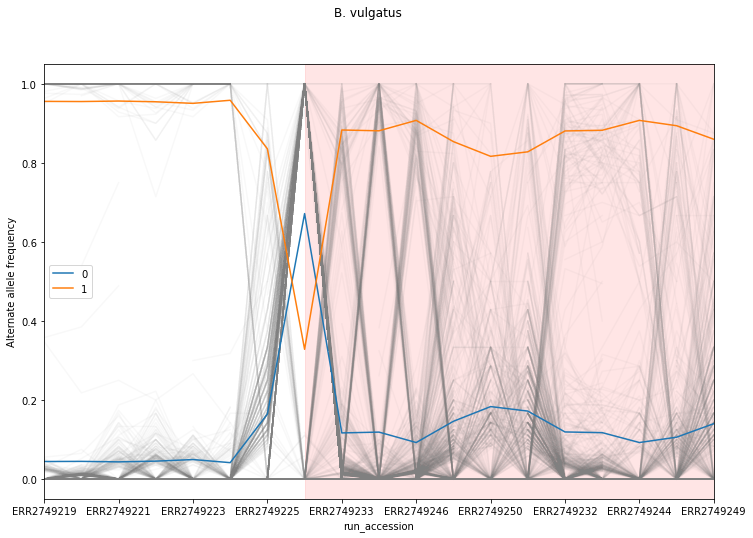

In [32]:
fig,ax = plt.subplots(figsize=(12,8))

fig.suptitle(fu.get_abbreviated_species_name(species))

for Fc in cluster_trajectories:
    Fc[:1000].T.plot(ax=ax,color="grey",alpha=.05,legend=None);
       
df.T.plot(ax=ax)

ax.axvspan(7,18,color="red",alpha=.1)
ax.set_ylabel("Alternate allele frequency");

In [242]:
host_mtdt = config.df_ind.get_group(10)